In [1]:
import os
# Reqiured to suppress tensorflow annoying warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np

import spacy
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("./data/output.csv")

### Data Cleaning

In [3]:
# "review_text" nan are to be deleted. Other can stay.
df = df.dropna(subset=["review_text"])

# Remove invalid entries
df = df.loc[df["entry_date"] != "entry_date"]

# Remove duplicate entries
df = df.drop_duplicates(["offer_ref", "entry_id", "review_text"]).drop_duplicates("review_text")


In [4]:
# fix data types
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["purchase_date"] = pd.to_datetime(df["purchase_date"])
df["entry_id"] = df["entry_id"].astype(int)
df["offer_ref"] = df["offer_ref"].astype(int)
df["score"] = df["score"].astype(float)

In [5]:
# Get Sentiment Cases based on score
df["sentiment"] = df["score"].apply(lambda x: "Positive" if x >= 4 else "Negative" if x <= 2 else "Neutral")

In [6]:
df["review_text"] = df["review_text"].replace("\n", " ", regex=True).replace("_+", " ", regex=True)

### Training Data Prep

In [7]:
# Get data to train the model on.
data_cleaned = df[["review_text", "sentiment"]].reset_index(drop=True).copy()

In [8]:
# Get Language Model
nlp = spacy.load("pl_core_news_lg")

In [9]:
# Apply tokenizer (TAKES ROUGHLY 5 mins!!! on 40K reviews)
data_cleaned["review_text"] = data_cleaned["review_text"].transform(lambda x: nlp(x))

In [10]:
data_cleaned["vectored_form"] = (
    data_cleaned["review_text"].transform(lambda x: # x is a Doc object
        tf.convert_to_tensor( # calculate mean of word vectors for each sentence. Tensors have different number of sentences.
            [tf.reduce_mean(tf.constant([token.vector for token in sentence], dtype=tf.float64), 0) for sentence in x.sents]
        )
    )
)

In [11]:
# Prepare target for categorical crossentropy
data_cleaned["target"] = LabelEncoder().fit_transform(data_cleaned["sentiment"])

In [12]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size] 
        batch_x = tf.convert_to_tensor([tf.pad(x, [[0, 90 - x.shape[0]], [0, 0]]) for x in batch_x])
        batch_y = tf.keras.utils.to_categorical(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], num_classes=3)
        return batch_x, batch_y

In [13]:
# data_cleaned["vectored_form"].to

In [14]:
# tf.pad(data_cleaned["vectored_form"].iloc[11002], [[0, 90 - data_cleaned["vectored_form"].iloc[11002].shape[0]], [0, 0]])

In [15]:
# data_cleaned["vectored_form"].transform(lambda x: tf.pad(x, [[0, 90 - x.shape[0]], [0, 0]]))

In [16]:
# tfds = tf.data.Dataset.from_tensor_slices((data_cleaned["vectored_form"], data_cleaned["target"]))

In [34]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data_cleaned["vectored_form"], data_cleaned["target"], test_size=0.2, random_state=42)
# Further split to get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

train_gen = DataGenerator(X_train, y_train, 32)
val_gen = DataGenerator(X_val, y_val, 32)
test_gen = DataGenerator(X_test, y_test, 32)

In [50]:


# Clear session
keras.backend.clear_session()

# model initialization
model = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(96), input_shape=(90, 300)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

# compile model with loss suited for 3 categories: "Positive", "Negative", "Neutral"
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.00005),
              metrics=['accuracy'],
)

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 192)              304896    
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                6176      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 311,171
Trainable params: 311,171
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Pad the data to have the same number of sentences in each review, the maximal number is 90
# data_cleaned["padded_vectored_form"] = data_cleaned["vectored_form"].transform(lambda x: tf.pad(x, [[0, 90 - x.shape[0]], [0, 0]]))

In [52]:
# Fit Model and save history
history = model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10


971/971 [==============================] - 12s 10ms/step - loss: 0.8608 - accuracy: 0.6131 - val_loss: 0.7631 - val_accuracy: 0.6623
Epoch 2/10
971/971 [==============================] - 9s 9ms/step - loss: 0.7351 - accuracy: 0.6844 - val_loss: 0.7214 - val_accuracy: 0.6841
Epoch 3/10
971/971 [==============================] - 9s 9ms/step - loss: 0.6969 - accuracy: 0.7056 - val_loss: 0.6865 - val_accuracy: 0.7070
Epoch 4/10
971/971 [==============================] - 9s 9ms/step - loss: 0.6719 - accuracy: 0.7176 - val_loss: 0.6790 - val_accuracy: 0.7093
Epoch 5/10
971/971 [==============================] - 10s 10ms/step - loss: 0.6536 - accuracy: 0.7267 - val_loss: 0.6656 - val_accuracy: 0.7194
Epoch 6/10
971/971 [==============================] - 9s 9ms/step - loss: 0.6359 - accuracy: 0.7349 - val_loss: 0.6721 - val_accuracy: 0.7206
Epoch 7/10
971/971 [==============================] - 9s 9ms/step - loss: 0.6227 - accuracy: 0.7435 - val_loss: 0.6657 - val_accuracy: 0.7130
Epoch 8/10
97

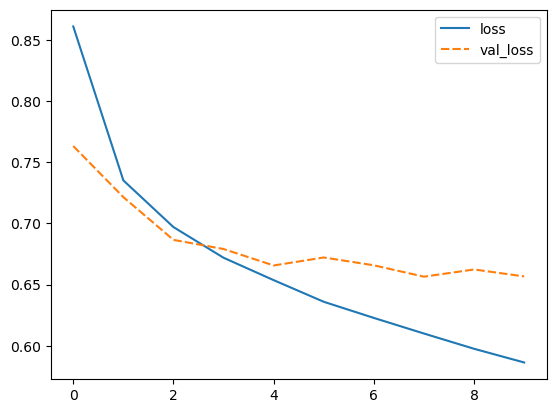

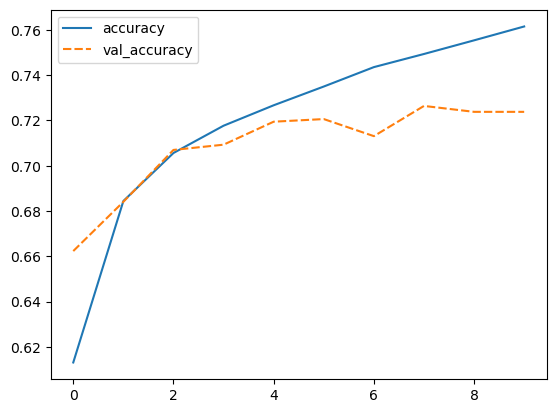

In [53]:
# plot loss history using seaborn

sns.lineplot(data=pd.DataFrame(history.history)[["loss", "val_loss"]])
plt.show()

# plot accuracy history using seaborn
sns.lineplot(data=pd.DataFrame(history.history)[["accuracy", "val_accuracy"]])
plt.show()

In [54]:
model.evaluate(test_gen)

  1/270 [..............................] - ETA: 9s - loss: 0.6164 - accuracy: 0.7500

270/270 [==============================] - 2s 7ms/step - loss: 0.6525 - accuracy: 0.7204


[0.652510941028595, 0.7203802466392517]